<a href="https://colab.research.google.com/github/maria-jahan20/Teeth-detection-using-VLM/blob/main/Paligemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q roboflow
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install supervision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


##Dataset

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="fwZ8YmD6kXjTnpU7rfQO")
project = rf.workspace("teethsegmentation").project("final_dataset-tznt6")
version = project.version(5)
dataset = version.download("paligemma")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to final_dataset-5 in paligemma:: 100%|██████████| 458/458 [00:00<00:00, 2861.91it/s]


##Imports

In [3]:
import cv2
import json
import supervision as sv
from typing import List
import os
import sys
from google.colab import userdata
import kagglehub

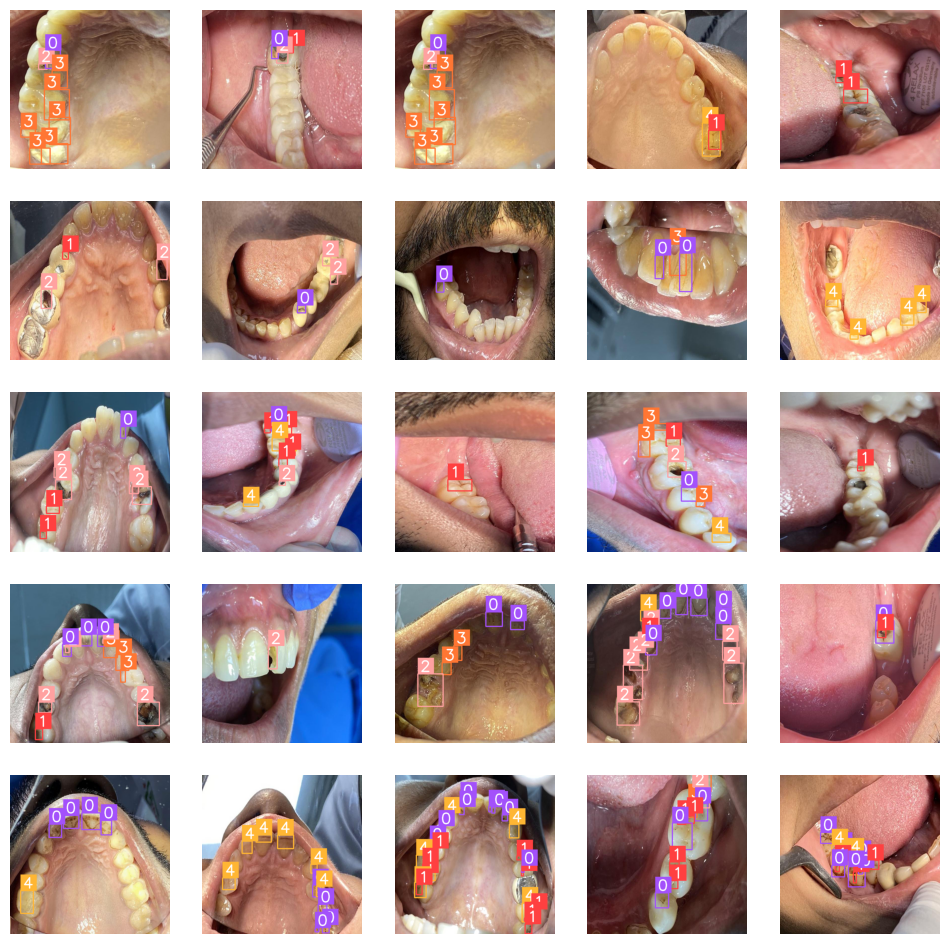

In [4]:
def read_n_lines(file_path: str, n: int) -> List[str]:
    with open(file_path, 'r') as file:
        lines = [next(file).strip() for _ in range(n)]
    return lines

images = []
lines = read_n_lines(f"{dataset.location}/dataset/_annotations.train.jsonl", 25)
first = json.loads(lines[0])

CLASSES = first.get('prefix').replace("detect ", "").split(" ; ")

for line in lines:
    data = json.loads(line)
    image = cv2.imread(f"{dataset.location}/dataset/{data.get('image')}")
    (h, w, _) = image.shape
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=data.get('suffix'),
        resolution_wh=(w, h),
        classes=CLASSES)

    image = sv.BoxAnnotator(thickness=4).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (5, 5))

In [5]:
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.8 MB/s eta 0:00:00


##Kaggle Keys for model

In [6]:
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

##jax

In [7]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image
from tqdm.notebook import tqdm

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.33
JAX platform: gpu
JAX devices:  1


In [8]:
MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')
    print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

100%|██████████| 5.45G/5.45G [05:45<00:00, 16.9MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
\ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


In [9]:
# Define the model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)
params = paligemma.load(None, MODEL_PATH, model_config)

# Define the `decode` function from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [10]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return True
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params simultaneously
# requires more RAM than the T4 colab runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Printinting the params
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float32
img/Transformer/encoder_norm/scale                                               (1152,)                float32
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float32
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float32
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float32
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float32
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float32
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float32
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

##Data preprocessing

In [11]:
def preprocess_image(image, size=224):
  #resizing image
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()
  try:
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)

In [12]:
SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.train.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.valid.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})


def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


Training examples



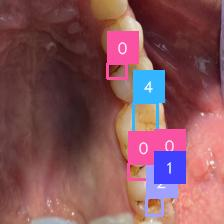
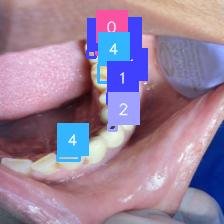
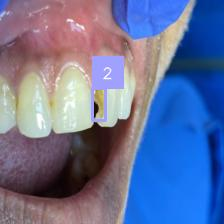
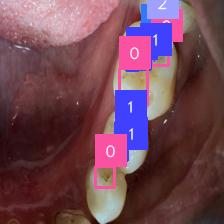

In [13]:
def split_and_keep_second_part(s):
    parts = s.split('\n', 1)
    if len(parts) > 1:
        return parts[1]
    return s

def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
    image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    h, w, _ = image.shape
    try:
        detections = sv.Detections.from_lmm(
            lmm='paligemma',
            result=caption,
            resolution_wh=(w, h),
            classes=CLASSES)
        image = sv.BoxAnnotator().annotate(image, detections)
        image = sv.LabelAnnotator().annotate(image, detections)
    except:
        print(caption)
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
    <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
</div>
"""

html_out = ""
for idx, example in zip(range(4), train_data_iterator()):
    caption = postprocess_tokens(example["text"])  # detokenize model input.
    caption = split_and_keep_second_part(caption)
    html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

In [14]:
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example
    # normalizing the examples
    token_pplx = jnp.sum(logp * targets, axis=-1)
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)

    # batch_loss
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# evaluation
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Padded by repeating last example if there's not enough example in the batch
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)


    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]
    labels = [postprocess_tokens(e["label"]) for e in examples]
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, label, response in zip(examples, labels, responses):
      outputs.append((example["image"], label, response))
      if num_examples and len(outputs) >= num_examples:
        return outputs


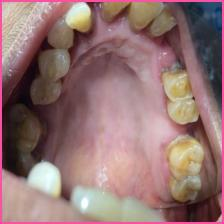
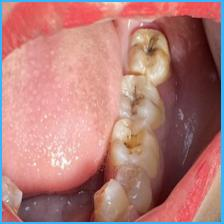
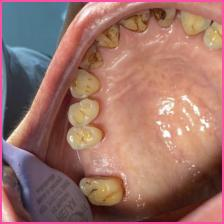
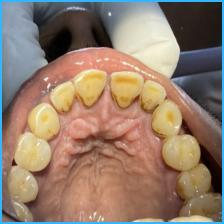

In [15]:
html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), num_examples=4, batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))

step:  1/57   lr: 0.00017   loss: 3.2102
step:  2/57   lr: 0.00033   loss: 3.8171
step:  3/57   lr: 0.00050   loss: 3.3749
step:  4/57   lr: 0.00067   loss: 3.2995
step:  5/57   lr: 0.00083   loss: 2.9742
step:  6/57   lr: 0.00100   loss: 3.5194
step:  7/57   lr: 0.00100   loss: 3.1346
step:  8/57   lr: 0.00100   loss: 2.9799
step:  9/57   lr: 0.00099   loss: 3.0956
Model predictions at step 9



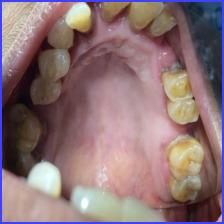
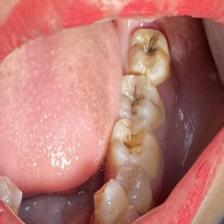
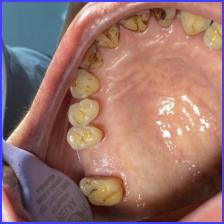
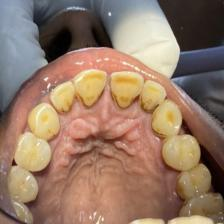

step: 10/57   lr: 0.00099   loss: 3.0431
step: 11/57   lr: 0.00098   loss: 2.8705
step: 12/57   lr: 0.00097   loss: 3.4961
step: 13/57   lr: 0.00096   loss: 2.9707
step: 14/57   lr: 0.00094   loss: 2.9207
step: 15/57   lr: 0.00093   loss: 2.8948
step: 16/57   lr: 0.00091   loss: 3.0110
step: 17/57   lr: 0.00089   loss: 3.1875
step: 18/57   lr: 0.00087   loss: 2.8560
Model predictions at step 18



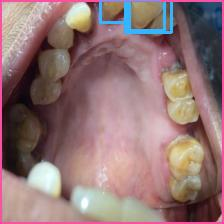
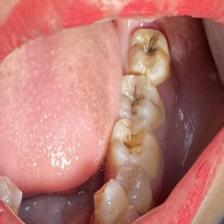
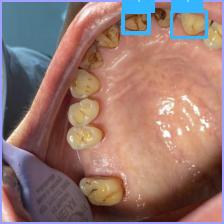
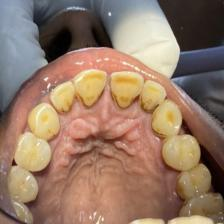

step: 19/57   lr: 0.00085   loss: 2.8154
step: 20/57   lr: 0.00083   loss: 3.2161
step: 21/57   lr: 0.00081   loss: 2.8418
step: 22/57   lr: 0.00078   loss: 3.0316
step: 23/57   lr: 0.00076   loss: 2.9590
step: 24/57   lr: 0.00073   loss: 3.1807
step: 25/57   lr: 0.00071   loss: 2.8886
step: 26/57   lr: 0.00068   loss: 2.7788
step: 27/57   lr: 0.00065   loss: 2.8982
Model predictions at step 27



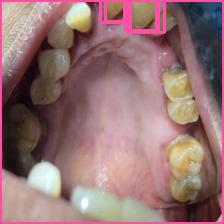
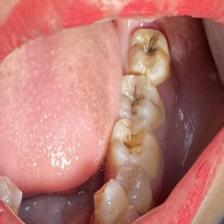
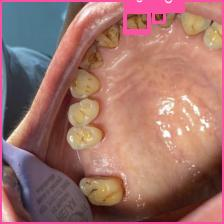
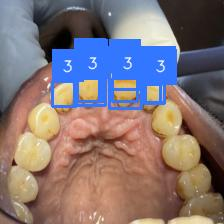

step: 28/57   lr: 0.00062   loss: 2.7663
step: 29/57   lr: 0.00059   loss: 3.0972
step: 30/57   lr: 0.00056   loss: 2.8248
step: 31/57   lr: 0.00053   loss: 2.8247
step: 32/57   lr: 0.00050   loss: 2.7409
step: 33/57   lr: 0.00047   loss: 3.0007
step: 34/57   lr: 0.00044   loss: 2.6836
step: 35/57   lr: 0.00041   loss: 2.9237
step: 36/57   lr: 0.00038   loss: 2.9348
Model predictions at step 36



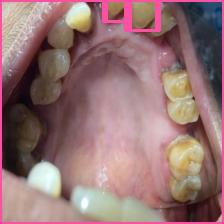
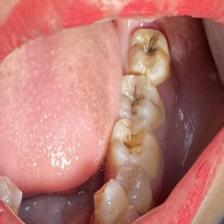
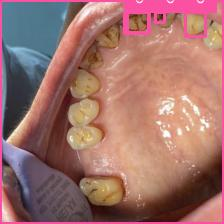
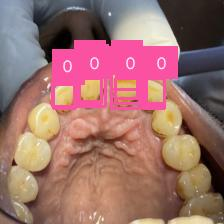

step: 37/57   lr: 0.00035   loss: 2.9187
step: 38/57   lr: 0.00032   loss: 2.8060
step: 39/57   lr: 0.00029   loss: 2.7061
step: 40/57   lr: 0.00027   loss: 2.7246
step: 41/57   lr: 0.00024   loss: 3.3553
step: 42/57   lr: 0.00022   loss: 2.8464
step: 43/57   lr: 0.00019   loss: 2.7960
step: 44/57   lr: 0.00017   loss: 2.7915
step: 45/57   lr: 0.00015   loss: 2.9279
Model predictions at step 45



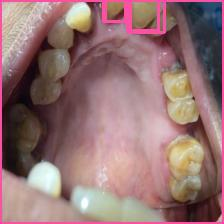
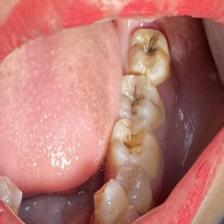
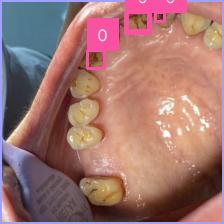
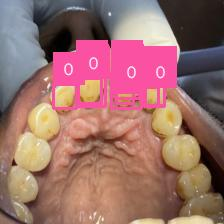

step: 46/57   lr: 0.00013   loss: 2.7836
step: 47/57   lr: 0.00011   loss: 3.0376
step: 48/57   lr: 0.00009   loss: 3.0693
step: 49/57   lr: 0.00007   loss: 2.8062
step: 50/57   lr: 0.00006   loss: 3.4993
step: 51/57   lr: 0.00004   loss: 2.6711
step: 52/57   lr: 0.00003   loss: 2.7389
step: 53/57   lr: 0.00002   loss: 2.6352
step: 54/57   lr: 0.00001   loss: 2.6860
Model predictions at step 54



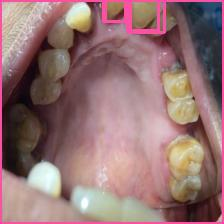
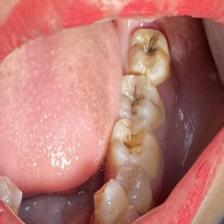
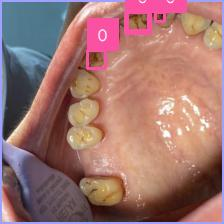
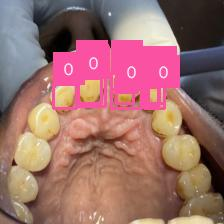

step: 55/57   lr: 0.00001   loss: 2.8361
step: 56/57   lr: 0.00000   loss: 2.9183
step: 57/57   lr: 0.00000   loss: 3.0022
CPU times: user 2min 34s, sys: 1min 7s, total: 3min 41s
Wall time: 5min 32s


In [16]:
%%time

BATCH_SIZE = 2
TRAIN_EXAMPLES = 114
LEARNING_RATE = 0.001

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 6

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, _, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))


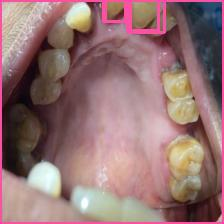
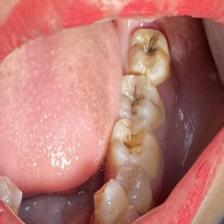
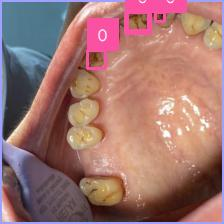
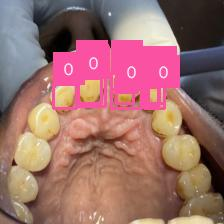
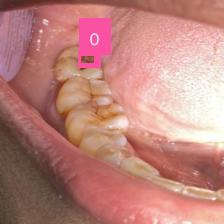
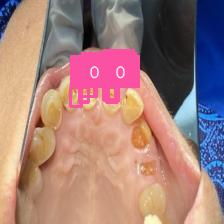
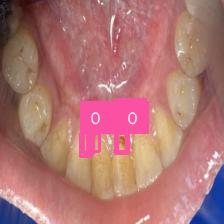
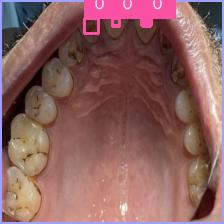
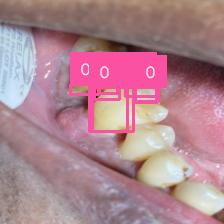
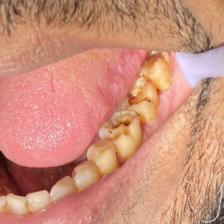
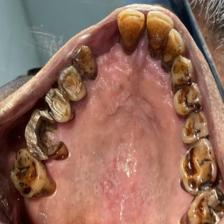

In [17]:
#Visualize results
html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), num_examples=11, batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))

In [18]:
# predictions
targets = []
predictions = []

for image, label, prediction in make_predictions(validation_data_iterator(), num_examples=25, batch_size=2):
    h, w, _ = image.shape
    target = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label,
        resolution_wh=(w, h),
        classes=CLASSES)
    targets.append(target)
    prediction = sv.Detections.from_lmm(
        lmm='paligemma',
        result=prediction,
        resolution_wh=(w, h),
        classes=CLASSES)
    prediction.confidence = np.ones(len(prediction))
    predictions.append(prediction)

##Mean Average Precesion

In [19]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.00
map50: 0.00
map75: 0.00


In [21]:
from sklearn.metrics import precision_score, recall_score

# Initialize lists for true and predicted labels
y_true = []
y_pred = []

for target, prediction in zip(targets, predictions):
    # Debugging: Print lengths
    print(f"Target id name:{target.class_id}")
    print(f"Target length: {len(target.class_id)}, Prediction length: {len(prediction.class_id)}")

    # Align lengths if there's a mismatch
    min_length = min(len(target.class_id), len(prediction.class_id))
    y_true.extend(target.class_id[:min_length].tolist())
    y_pred.extend(prediction.class_id[:min_length].tolist())

# Calculate precision and recall
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Target id name:[4 4 4 4 0 0]
Target length: 6, Prediction length: 16
Target id name:[1 0 0 0 0 0 1]
Target length: 7, Prediction length: 0
Target id name:[4 4 4 4 4 4 0 0 0 0 0 0 2]
Target length: 13, Prediction length: 16
Target id name:[4 4 4 4 4 4 4 0 0 0 0 0 0 1 1 0]
Target length: 16, Prediction length: 16
Target id name:[0 3 1 1 1]
Target length: 5, Prediction length: 16
Target id name:[2 2 2 2 2 4 4 4 4]
Target length: 9, Prediction length: 16
Target id name:[3 3 1 1 1 0 0 0 0 0 0 1]
Target length: 12, Prediction length: 16
Target id name:[0 0 0 0 0 0 0 0 0 0 0 1 0]
Target length: 13, Prediction length: 16
Target id name:[0 1 1 1 0]
Target length: 5, Prediction length: 16
Target id name:[2 1 4 2]
Target length: 4, Prediction length: 0
Target id name:[0 0 0 0 0 0 0 4 4 4 4 2 4 4 4 0]
Target length: 16, Prediction length: 0
Target id name:[1 1]
Target length: 2, Prediction length: 16
Target id name:[2 1 3 3 0 0 0 0]
Target length: 8, Prediction length: 0
Target id name:[1 1 1 4 1 

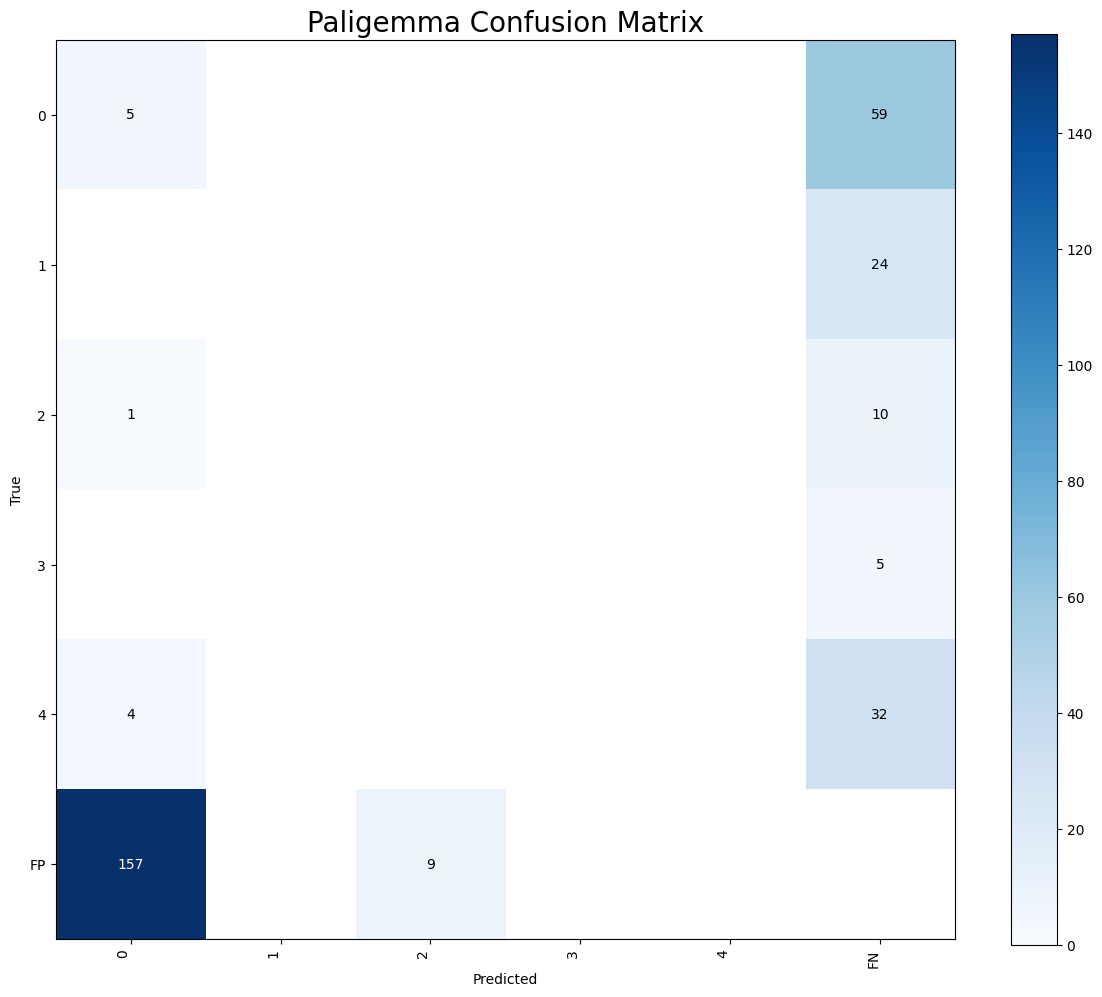

In [25]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot(title="Paligemma Confusion Matrix")
